In [1]:

import vtk
import os
import numpy as np
import itertools
import math, random
import data_process_ml
random.seed = 42
import copy

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms, utils

import scipy.spatial.distance
# import plotly.graph_objects as go
# import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix




In [2]:
import open3d as o3d
def reduce_mesh(target_mesh, reference_mesh):
    # Find common vertices between the two meshes
    output_mesh = copy.deepcopy(target_mesh)
    target_vertices = set(tuple(vertex) for vertex in np.asarray(target_mesh.vertices))
    target_vertices_list = [tuple(vertex) for vertex in np.asarray(target_mesh.vertices)]
    index_dict = {item: index for index, item in enumerate(target_vertices_list)}
    reference_vertices = set(tuple(vertex) for vertex in np.asarray(reference_mesh.vertices))

    common_vertices = target_vertices.intersection(reference_vertices)
    #print(len(list(common_vertices)))
    list_mine = [index_dict[element_to_find] for element_to_find in list(common_vertices)]

    #print(list_mine)

    # Filter out vertices and triangles based on common vertices
    output_mesh.remove_vertices_by_index(list_mine)

    return output_mesh

def mesh_to_point_cloud(file_path,points = 10000):
    """
    Convert a mesh object to a point cloud object.
    """
    mesh = o3d.io.read_triangle_mesh(file_path)
    point_cloud = mesh.sample_points_uniformly(number_of_points=points) # Adjust number_of_points as needed
    return point_cloud

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
import vtk
import numpy as np

def vtp_to_mesh(file_path):
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(file_path)
    reader.Update()
    polydata = reader.GetOutput()

    vertices = np.array(polydata.GetPoints().GetData())
    polygons = np.array(polydata.GetPolys().GetData())

    # Extract vertices
    vertices = vertices.reshape(-1, 3)

    # Extract faces
    faces = polygons.reshape(-1, 4)[:, 1:]  

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    return mesh

def vtp_to_point_cloud(file_path,points = 10000):
    mesh = o3d.geometry.TriangleMesh()
    if ".vtp" not in file_path:
        mesh = o3d.io.read_triangle_mesh(file_path)
    else:
        mesh = vtp_to_mesh(file_path)
        
    #o3d.visualization.draw_geometries([mesh])
    # if (len(mesh.vertices))>10000:
    #     print(len(mesh.vertices))

    point_cloud = mesh.sample_points_uniformly(number_of_points=points)

    return point_cloud

def vtp_to_point_cloud_cutvessel(vessel_file_path,cut_file_path, points = 10000):
    """
    Convert a mesh object to a point cloud object.
    """
    if ".vtp" not in vessel_file_path:
        vessel_mesh = o3d.io.read_triangle_mesh(vessel_file_path)
    else:
        vessel_mesh = vtp_to_mesh(vessel_file_path)
    if ".vtp" not in cut_file_path:
        cut_mesh = o3d.io.read_triangle_mesh(cut_file_path)
    else:
        cut_mesh = vtp_to_mesh(cut_file_path)
    
    box_mesh = cut_mesh.get_axis_aligned_bounding_box()
    reduced_mesh =  vessel_mesh.crop(box_mesh) 
    result_mesh = reduce_mesh(vessel_mesh,reduced_mesh)
    #print(cut1_mesh,result_mesh)
    # if vessel_mesh.vertices == result_mesh.vertices:
    #     return False
                  
    #o3d.visualization.draw_geometries([result_mesh])
    #o3d.visualization.draw_geometries([reduced_mesh])
    # if (len(vessel_mesh.vertices))>10000:
    #     print("larger")
    
    point_cloud = result_mesh.sample_points_uniformly(number_of_points=points) # Adjust number_of_points as needed
    return point_cloud



load the dataset

In [4]:
root = "..\..\msc_data\models-v1.0\models"
IA = "aneurysms\\remeshed\\area-001"
Vessel = "vessels\\remeshed\\area-001"
IA_root = os.path.join(root,IA)
Vessel_root = os.path.join(root,Vessel)
list1 = os.listdir(Vessel_root)
list2 = os.listdir(IA_root)

In [5]:
morpho_path = ".\AneuX\data-v1.0\data\morpho-per-cut.csv"
patient_path = ".\AneuX\data-v1.0\data\clinical.csv"
morpho_data_patient = data_process_ml.read_and_combine_data(morpho_path,patient_path)
merged_dataset = data_process_ml.encode_column(morpho_data_patient)
merged_dataset = data_process_ml.drop_columns(merged_dataset)
morpho_data_cut1,morpho_data_dome = data_process_ml.output_cut1anddome(merged_dataset)

d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(morpho_data_cut1.columns[3:23], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(['source_x',"cuttype","dataset"], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [6]:
import pandas as pd
from pointnetfunct.PointNet_dataset import Aneux_Dataset_load
df = pd.DataFrame()
# Aneux_Dataset = Aneuxmodel_Dataset(root = root,
#                                    df=morpho_data_patient[morpho_data_patient["cuttype"] == "dome"],
#                                    transform = transforms.ToTensor(),
#                                    mesh = "area-001",
#                                    cuttype = "dome",
#                                    crop = False)

Aneux_Dataset = Aneux_Dataset_load('./Aneux_Dataset_2000pt_sample_train.pt')
Aneux_Dataset.paraout = True
Aneux_Dataset_test = Aneux_Dataset_load('./Aneux_Dataset_2000pt_sample_100test.pt')

d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(morpho_data_cut1.columns[3:23], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(['source_x',"cuttype","dataset"], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [7]:
print(len(Aneux_Dataset.model_table),len(Aneux_Dataset.label))
print(Aneux_Dataset.points)

600 600
2000


In [10]:
from torch.utils.data import Subset

#torch.manual_seed(25447239782700)

train_size = int(len(Aneux_Dataset) * 0.85) # 80% training data
valid_size = len(Aneux_Dataset) - train_size
train_data, valid_data = random_split(Aneux_Dataset, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=50,
    shuffle=True,
    #num_workers=2, 
    pin_memory=True
)

valid_loader = torch.utils.data.DataLoader(
    valid_data,
    batch_size=50, # Forward pass only so batch size can be larger
    shuffle=False,
    #num_workers=2, 
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    Aneux_Dataset_test,
    batch_size=50, # Forward pass only so batch size can be larger
    shuffle=False,
    #num_workers=2, 
    pin_memory=True
)

Test vaildation

In [12]:
file = "\\C0006"
model_list = []
for model_name in list1[:1]:
    file = model_name[:-4]
    Vessel_root_file = Vessel_root + "\\" + file + ".vtp"
    
    IA_name_cut1 = ""
    IA_name_dome = ""
    for IA_model in list2:
        
        if file in IA_model and "cut1" in IA_model and file not in IA_name_cut1:
            print("find:" + IA_model)
            IA_name_cut1 = IA_model
        elif file.split("_")[0] in IA_model and "cut1" in IA_model and IA_name_cut1 == "":
            IA_name_cut1 = IA_model
            
        if file in IA_model and "dome" in IA_model and file not in IA_name_dome:
            IA_name_dome = IA_model
        elif file.split("_")[0] in IA_model and "dome" in IA_model and IA_name_dome == "":
            IA_name_dome = IA_model
            
        if IA_name_cut1 != "" and IA_name_dome != "" and file in IA_name_cut1 and file in IA_name_dome:
            break
            
    print(IA_name_cut1)
    IA_root_file = os.path.join(IA_root,IA_name_cut1)
    modelcov_vtp = True
    if IA_name_cut1 != "" and IA_name_dome!= "":
        modelcov_vtp = vtp_to_point_cloud_cutvessel(Vessel_root_file,IA_root_file)
    if modelcov_vtp == False:
        print("Can not crop: " + file)
        print("Vessel root name: " + Vessel_root_file)
        print("IA root name: " + IA_root_file)
        break
         #o3d.visualization.draw_geometries([modelcov_vtp])
    else:
        model_list.append(modelcov_vtp)

find:ANSYS_UNIGE_09_cut1.vtp
ANSYS_UNIGE_09_cut1.vtp


In [13]:
print(len(list1),len(model_list))
print(model_list)

682 1
[PointCloud with 10000 points.]


# PointNet model

In [14]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch import optim
from pointnetfunct.PointNet_struct import Tnet,Transform,PointNet,PointNet_2Multihead,PointNet_3Multihead


Run model

In [16]:
import functions
from pointnetfunct.PointNet_trainingfunct import run_model_get,run_model_3multi_head_dnn,run_model_2multi_head_dnn,load_model
from pointnetfunct.PointNet_struct import PointNet,PointNet_2Multimodal_withDNN,PointNet_3Multihead_withDNN

pointnet = PointNet(classes=2)
run_model_get(train_loader_input = train_loader,
                        vaild_loader_input = valid_loader,
                        nepochs = 100, 
                        modelnet = pointnet,
                        results_path = "./result", 
                        filename = "/dome_200pt_test.pt",
                        model_name="pointnet_2000pt.pth")
pointnet.to("cpu")

epoch: 0 training loss:  0.696 training accuracy:  62.1%  test loss:  0.647 test accuracy:  63.9%
epoch: 1 training loss:  0.671 training accuracy:  65.5%  test loss:  0.658 test accuracy:  63.3%
epoch: 2 training loss:  0.669 training accuracy:  65.6%  test loss:  0.654 test accuracy:  65.3%
epoch: 3 training loss:  0.664 training accuracy:  64.8%  test loss:  0.656 test accuracy:  64.6%
epoch: 4 training loss:  0.669 training accuracy:  64.3%  test loss:  0.603 test accuracy:  68.0%
epoch: 5 training loss:  0.671 training accuracy:  64.5%  test loss:  0.671 test accuracy:  65.3%
epoch: 6 training loss:  0.657 training accuracy:  64.3%  test loss:  0.641 test accuracy:  66.0%
epoch: 7 training loss:  0.667 training accuracy:  62.6%  test loss:  0.631 test accuracy:  66.0%
epoch: 8 training loss:  0.662 training accuracy:  64.8%  test loss:  0.684 test accuracy:  64.6%
epoch: 9 training loss:  0.664 training accuracy:  65.0%  test loss:  0.636 test accuracy:  66.0%
epoch: 10 training l

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

In [17]:
def show_graph(path,device):
    data = torch.load(path, map_location=device) # by doing map_location=device, you can use trained model on GPU --> to test on CPU
    statsrec = data["stats"]
    fig, ax1 = plt.subplots()
    plt.plot(statsrec[0], 'r', label = 'training loss', )
    plt.plot(statsrec[2], 'g', label = 'test loss' )
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training and test loss, and test accuracy')
    ax2=ax1.twinx()
    ax2.plot(statsrec[1], 'm', label = 'training accuracy')
    ax2.plot(statsrec[3], 'b', label = 'test accuracy')
    ax2.set_ylabel('accuracy')
    plt.legend(loc='upper right')
    fig.savefig("roc.svg")
    plt.show()

In [ ]:
device = torch.device('cuda:0')
show_graph(path ="./result/3multibranch_test.pt",device = "cuda")

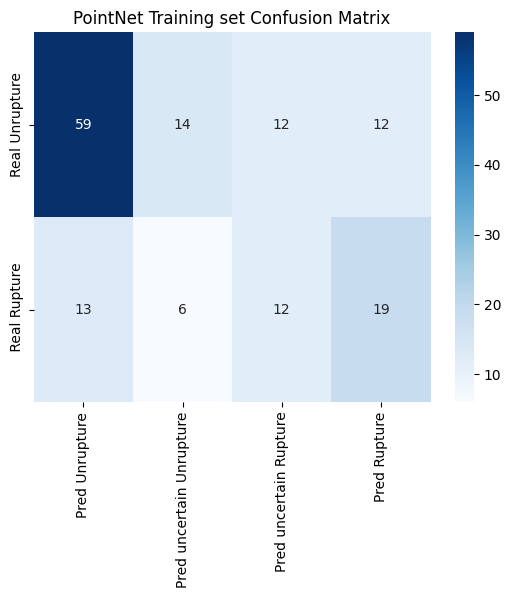

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import functions as fun
pointnet_copy = PointNet(classes=2)
model_path = "./pointnet_2000pt.pth"
load_model(pointnet_copy,model_path)

y_true = []
y_pred = []
y_pred_result = []
y_probs = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,_,_,labels in valid_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)

from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph

draw_rocgraph(y_pred_result,y_true, y_probs, name="1000pt_2branch_AOC", interval=0.04)
show_cm_dl(y_true, y_pred,y_pred_result,name="1000pt_2branch_CM")
print_values (y_true, y_pred_result)


Multi head

3multihead

In [24]:
import functions
pointnet_mh = PointNet_3Multihead(classes=2)
run_model_3multi_head_dnn(train_loader_input = train_loader,
                        vaild_loader_input = valid_loader,
                        nepochs = 100, 
                        modelnet = pointnet_mh,
                        results_path = "./result", 
                        filename = "/3multibranch_test.pt"
                        model_name="pointnet_3branch_modal_2000pt.pth")

epoch: 0 training loss:  0.687 training accuracy:  65.6%  test loss:  0.670 test accuracy:  64.6%
epoch: 1 training loss:  0.660 training accuracy:  68.4%  test loss:  0.597 test accuracy:  71.4%
epoch: 2 training loss:  0.641 training accuracy:  68.4%  test loss:  0.647 test accuracy:  68.0%
epoch: 3 training loss:  0.638 training accuracy:  66.8%  test loss:  0.586 test accuracy:  67.3%
epoch: 4 training loss:  0.638 training accuracy:  67.2%  test loss:  0.601 test accuracy:  68.7%
epoch: 5 training loss:  0.644 training accuracy:  66.7%  test loss:  0.565 test accuracy:  72.8%
epoch: 6 training loss:  0.604 training accuracy:  69.6%  test loss:  0.599 test accuracy:  69.4%
epoch: 7 training loss:  0.611 training accuracy:  68.5%  test loss:  0.567 test accuracy:  69.4%
epoch: 8 training loss:  0.582 training accuracy:  71.1%  test loss:  0.527 test accuracy:  75.5%
epoch: 9 training loss:  0.612 training accuracy:  70.9%  test loss:  0.586 test accuracy:  70.7%
epoch: 10 training l

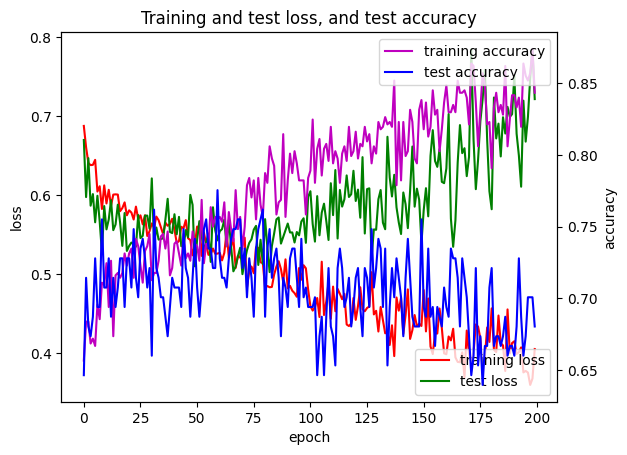

In [25]:
device = torch.device('cuda:0')
show_graph(path ="./result/3multibranch_test.pt",device = "cuda")

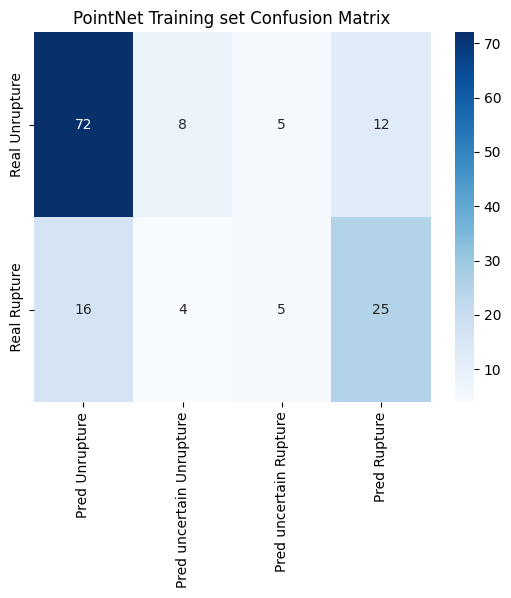

In [26]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import functions as fun
pointnet_copy = PointNet(classes=2)
model_path = "./pointnet_3branch_modal_2000pt.pth"
load_model(pointnet_copy,model_path)

y_true = []
y_pred = []
y_pred_result = []
y_probs = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,_,_,labels in valid_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)

from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph

draw_rocgraph(y_pred_result,y_true, y_probs, name="1000pt_2branch_AOC", interval=0.04)
show_cm_dl(y_true, y_pred,y_pred_result,name="1000pt_2branch_CM")
print_values (y_true, y_pred_result)